# Search Book
Given a query (question), search the best corresponding chunks in the Cisco CCNA Book using Facebook AI Similarity Search (FAISS) library. FAISS has excellent GPU implementation of "brute-force" kNN (meaning that no approximation techniques compromising the accuracy of the search).

In [93]:
import sys
import time
import re
import string

from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import torch
from transformers import BertModel, BertTokenizer
from keras.preprocessing.sequence import pad_sequences

import faiss
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2, style="whitegrid", font="sans-serif")


def load_chunks(filepath):
    """
    Load the chunk embeddings of the text file.
    """
    # Load dataframe.
    df = pd.read_hdf(filepath)
    
    # Get chunks and their embeddings.
    chunks = df.iloc[:,-1].values
    embeddings = df.iloc[:,:-1].values
    embeddings = np.ascontiguousarray(embeddings, dtype=np.float32) # Necessary for FAISS indexing afterwards.
    
    return chunks, embeddings


def create_gpu_index(vecs, n_gpus, method):
    """
    Create FAISS index on GPU(s).
    To create a GPU index with FAISS, one first needs to create it on CPU then copy it on GPU. 
    Note that a "flat" index means that it is brute-force, with no approximation techniques.
    """
    # Build flat CPU index.
    if method=='l2':
        cpu_index = faiss.IndexFlatL2(vecs.shape[1])  # Exact Search for L2
    elif method=='ip':
        cpu_index = faiss.IndexFlatIP(vecs.shape[1])  # Exact Search for Inner Product (also for cosine, just normalize vectors beforehand)
    else:
        print("Error: Please choose between L2 distance ('l2') or Inner Product ('ip') as brute-force method for exact search. Exiting...")
        sys.exit(0)
    
    # Convert to flat GPU index.
    co = faiss.GpuMultipleClonerOptions()  # If using multiple GPUs, enable sharding so that the dataset is divided across the GPUs rather than replicated.
    co.shard = True
    gpu_index = faiss.index_cpu_to_all_gpus(cpu_index,co=co, ngpu=n_gpus)  # Convert CPU index to GPU index.
    
    # Add vectors to GPU index.
    gpu_index.add(vecs)

    return gpu_index


def load_questions(filepath, questions_type):
    """
    """
    # Load dataframe.
    df = pd.read_csv(filepath, sep=";")

    if questions_type is None:
        # Get all questions and their associated answers.
        questions = df.Question.values
        answers = df.Answer.values
    else:
        # Get questions of given type and associated answers.
        questions = df[df['QuestionType'] == questions_type].Question.values
        answers = df[df['QuestionType'] == questions_type].Answer.values
    
    return questions, answers


def encode_sentences(model_name_or_path, cache, sentences):
    """
    Given a list of sentences and a model, get the embeddings of theses sentences
    as the average of the word embeddings of the last layer.
    """
    print("   Loading pretrained model/tokenizer...")
    tokenizer = BertTokenizer.from_pretrained(model_name_or_path)
    model = BertModel.from_pretrained(model_name_or_path, output_hidden_states=True, cache_dir=cache) # Will output all hidden_states.

    print("   Tokenizing sentences...")
    tokenized = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences]

    lengths = [len(i) for i in tokenized]
    max_len = max(lengths) if max(lengths) <= 512 else 512

    print("   Padding/Truncating sentences to {} tokens...".format(max_len))
    padded = pad_sequences(tokenized, maxlen=max_len, dtype="long", 
                          value=0, truncating="post", padding="post")

    print("   Creating attention masks...")
    attention_mask = np.where(padded != 0, 1, 0)  #returns ndarray which is 1 if padded != 0 is True and 0 if False.

    print("   Converting inputs to torch tensors...")
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print("   Encoding sentences...")
    with torch.no_grad():
        # output is a 2-tuple where:
        #  - output[0] is the last_hidden_state, i.e a tensor of shape (batch_size, sequence_length, hidden_size).
        #  - output[1] is the pooler_output, i.e. a tensor of shape (batch_size, hidden_size) being the last layer hidden-state of the first token of the sequence (classification token).
        #  - output[2] are all hidden_states, i.e. a 13-tuple of torch tensors of shape (batch_size, sequence_length, hidden_size): 12 encoders-outputs + initial embedding outputs.
        output = model(input_ids, attention_mask=attention_mask)

    # For each sentence, take the embeddings of its word from the last layer and represent that sentence by their average.
    last_hidden_states = output[0]
    sentence_embeddings = [torch.mean(embeddings[:torch.squeeze((masks == 1).nonzero(), dim=1).shape[0]], dim=0).numpy() for embeddings, masks in zip(last_hidden_states, attention_mask)]
    sentence_embeddings = np.array(sentence_embeddings)
    
    return sentence_embeddings


def remove_punctuation(text):
    """
    Remove common punctuations.
    """
    return re.sub('([.,:;!?{}()])', r'', text)


def process_text(text):
    """
    """
    # Remove punctuations.
    processed = remove_punctuation(text)
    
    # Lower text.
    processed = processed.lower()
    
    # Remove stopwords.
    stop_words = stopwords.words('english')
    stop_words = [w for w in stop_words if w not in {'on', 'off'}]  # Let some stopwords very present in the computer networking field.
    processed = [w for w in processed.split() if w not in stop_words]
    return processed


def compute_score(chunk, answer):
    """
    """
    # Get all words from answer present in the chunk.
    words = [w for w in answer if w in chunk]
    
    # Define the score as the percentage of words from answer present in the chunk.
    score = (len(words)/len(answer))*100
    return score


def compute_delta_l2(row, topk):
    """
    Given a row of the dataframe, compute the L2 delta such as the differrence between
    the L2 distance of the best result and the one of the second best result.
    """
    # Get the column names.
    cols = row.index.values.tolist()

    # Get the scores of each result.
    scores_cols = [col for col in cols if col.startswith('score')]
    scores = [row[col] for col in scores_cols]

    # Create a tuples list with result index and associated score.
    results = [(idx, score) for idx, score in zip(range(1, topk+1, 1), scores)]

    # Sort it by highest score.
    sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
    if sorted_results[0][1] == 0:
        # If best result is 0, return null (search has not found the answer in a chunk).
        return np.nan

    # Get the L2 distances of best and second best results.
    best_col = 'l2_result' + str(sorted_results[0][0])
    sec_col = 'l2_result' + str(sorted_results[1][0])

    l2_best = row[best_col]
    l2_sec = row[sec_col]

    # Compute the delta in l2 between best and second best results.
    delta = abs(l2_best - l2_sec)
    return delta


def create_barplot(df, fig_name):
    """
    """
    # Create barplot.
    plt.figure(figsize=(25,10))
    ax = sns.barplot(x="Question", y="Best_result_score", data=df, color="salmon", saturation=.5)

    # Tweak graph.
    ax.set(xticklabels=[]) #range(df.shape[0])) # Replace x labels by query ids.
    plt.xlabel('Questions', fontsize=28)
    plt.ylabel('Search score', fontsize=28)

    # Horizontal line as avergage score.
    ax.axhline(y=df["Best_result_score"].mean(), ls='--', label="Mean score")
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles=handles, labels=labels, loc=(0.852,1.005))

    plt.savefig("./figures/" + fig_name + "_scores.pdf", bbox_inches='tight')
    plt.show()
    return


def create_piechart(df, show_k, fig_name):
    """
    """
    # For each question, get the id of the result chunk that had the highest search score.
    # Note that the id here is simply the order of appearance of the result chunks.
    all_count = df.Best_result.value_counts().sort_index()[1:]

    # In order not to plot the counts for all x result chunks, only keep the first 'show_k'
    # and sum up the counts of the remaining as one entity.
    sum_last = all_count[show_k:].sum()

    # Get the values and the labels of the show_k results.
    values = all_count[:show_k].values.tolist()
    labels = ['result '+str(i+1) for i in range(show_k)]

    # Append the sum of the remaining results.
    values.append(sum_last)
    labels.append('results > '+ str(show_k))

    # Create a new series as the counts of the show_k and the sum for > show_k.
    new_count = pd.Series(data=values, index=labels)

    # Create pie chart.
    fig, ax = plt.subplots(figsize=(25,8))
    new_count.plot(kind='pie', ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, labels=None)
    ax.set_ylabel('Highest search score')
    ax.legend(loc=(0.8,0.8), labels=labels)
    plt.savefig("./figures/" + fig_name + "_piechart.pdf", bbox_inches='tight')
    plt.show()
    return


def create_boxplots(df, fig_name):
    """
    """
    plt.figure(figsize=(15,10))
    ax = sns.boxplot(x="Best_result", y="delta_l2", data=df.dropna())
    ax.set_title('Delta L2 between 1st and 2nd top results', fontsize=16)
    ax.set_xlabel('Best result', fontsize=16)
    ax.set_ylabel('Delta L2', fontsize=16)
    plt.savefig("./figures/" + fig_name + "_boxplot.pdf", bbox_inches='tight')
    plt.show()
    return


def create_piechart_and_boxplots(df, show_k, fig_name):
    """
    """
    # Init figure.
    fig = plt.figure(figsize=(25,8))
    
    #----------------------------
    # PIE-CHART
    #----------------------------
    # For each question, get the id of the result chunk that had the highest search score.
    # Note that the id here is simply the order of appearance of the result chunks.
    all_count = df.Best_result.value_counts().sort_index()[1:]

    # In order not to plot the counts for all x result chunks, only keep the first 'show_k'
    # and sum up the counts of the remaining as one entity.
    sum_last = all_count[show_k:].sum()

    # Get the values and the labels of the show_k results.
    values = all_count[:show_k].values.tolist()
    labels = ['result '+str(i+1) for i in range(show_k)]

    # Append the sum of the remaining results.
    values.append(sum_last)
    labels.append('results > '+ str(show_k))

    # Create a new series as the counts of the show_k and the sum for > show_k.
    new_count = pd.Series(data=values, index=labels)

    # Create pie chart.
    ax1 = fig.add_subplot(1, 2, 1)
    new_count.plot(kind='pie', ax=ax1, autopct='%1.1f%%', startangle=270, fontsize=12, labels=None,colors=sns.color_palette("RdYlBu")[1:])
    ax1.set_ylabel('Highest search score', fontsize=28)
    ax1.legend(loc=(0.8,0.8), labels=labels)
    
    #----------------------------
    # BOXPLOTS
    #----------------------------
    ax2 = fig.add_subplot(1, 2, 2)
    ax2 = sns.boxplot(x="Best_result", y="delta_l2", data=df.dropna(), palette=sns.color_palette("RdYlBu")[1:])
    #ax2.set_title('Delta L2 between 1st and 2nd top results', fontsize=16)
    ax2.set_xlabel('Best result', fontsize=28, labelpad=20)
    ax2.set_ylabel('Delta L2 with 2nd best result', fontsize=28, labelpad=20)
    
    ax2.yaxis.set_ticks(np.arange(0, 5.5, 0.5))
    #ax2.set_ylim(top=4)
    
    # Show the plot.
    plt.savefig("./figures/" + fig_name + "_results.pdf", bbox_inches='tight')
    plt.show()
    return
    

def run(model_name_or_path, embeddings_filepath, questions_filepath, fig_name, questions_type="Knowledge",
        cache='/raid/antoloui/Master-thesis/_cache/', method='l2', n_gpus=1, topk=5):
    """
    """
    print("\nLoad chunks and their embeddings...") 
    chunks, embeddings = load_chunks(embeddings_filepath)
    
    print("\nCreate FAISS (GPU) index...")
    index = create_gpu_index(vecs=embeddings, 
                             n_gpus=n_gpus, 
                             method=method)
    
    print("\nLoad questions...")
    questions, answers = load_questions(questions_filepath, questions_type)
    
    print("\nEncode questions...")
    quest_embeddings = encode_sentences(model_name_or_path=model_name_or_path, 
                                             cache=cache,
                                             sentences=questions)
    
    
    # Create columns of results dataframe.
    cols = ['Question', 'Answer', 'Best_result_score', 'Best_result']
    result_cols = ['result'+str(i+1) for i in range(topk)]
    score_cols = ['score_result'+str(i+1) for i in range(topk)]
    l2_cols = ['l2_result'+str(i+1) for i in range(topk)]
    
    # Append them all together.
    cols.extend(result_cols)
    cols.extend(score_cols)
    cols.extend(l2_cols)
    
    # Create dataframe.
    df = pd.DataFrame(columns=cols)
    
    print("\nPerform evaluation...")
    # For each question-answer pair, compute a score according to the results of FAISS search.
    for i, (Q, E, A) in enumerate(tqdm(zip(questions, quest_embeddings, answers), total=len(questions))):
    
        # Process the answer.
        multiple_ans = A.split(';')
        processed_ans = [process_text(ans) for ans in multiple_ans]

        # Find topk chunks with FAISS search.
        result_dist, result_idx = index.search(E.reshape(1,768), k=topk)
        
        # Get these chunks and their L2 distances.
        result_chunks = [chunks[idx] for idx in result_idx[0]]
        result_distances = result_dist[0]

        # For each result chunk, compute a score. 
        # The score si defined as the percentage of words in the answer that appears in that chunk. 
        # If multiple answers are possible, the max score is taken.
        result_scores = []
        for k, (chunk,dist) in enumerate(zip(result_chunks,result_distances)):

            # Get the chunk and process it.
            processed_chunk = process_text(chunk)

            # Compute a score for that chunk according to each answer.
            scores_by_ans = [compute_score(processed_chunk, ans) for ans in processed_ans]

            # Take the maximum score out of the possible answers.
            chunk_score = max(scores_by_ans)

            # Append it to the scores list for topk chunks.
            result_scores.append(chunk_score)
            
        # Get the best score among all chunk results, and the associated best chunk id.
        best_score = max(result_scores)
        best_chunk = (result_scores.index(max(result_scores)) + 1) if max(result_scores) != 0.0 else 0
        
        # Add row to dataframe.
        new_row = [Q, A, best_score, best_chunk]
        new_row.extend(result_chunks)
        new_row.extend(result_scores)
        new_row.extend(result_distances)
        df = df.append(pd.Series(new_row, index=df.columns), ignore_index=True)
    
    print("  MEAN SCORE: {:.2f}".format(df["Best_result_score"].mean()))
    
    # Create a column computing the difference of the L2 distances between best and second best result.
    # This column is created for the boxplot visualisation.
    df['delta_l2'] = df.apply(lambda row: compute_delta_l2(row, topk), axis=1)
        
    print("\nPlot results...")
    create_barplot(df, fig_name)  # Barplot of the best scores for each question.
    #create_piechart(df, 3)  # Pie-chart of which were the best results.
    #create_boxplots(df)  # Boxplots comparing the L2 deltas bewteen best and second best result.
    create_piechart_and_boxplots(df, 3, fig_name)
    
    print("\nDone.")

## 1. "Knowledge" questions

### 1.1. NetBERT


Load chunks and their embeddings...

Create FAISS (GPU) index...

Load questions...

Encode questions...
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 70 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...

Perform evaluation...



  MEAN SCORE: 70.46

Plot results...


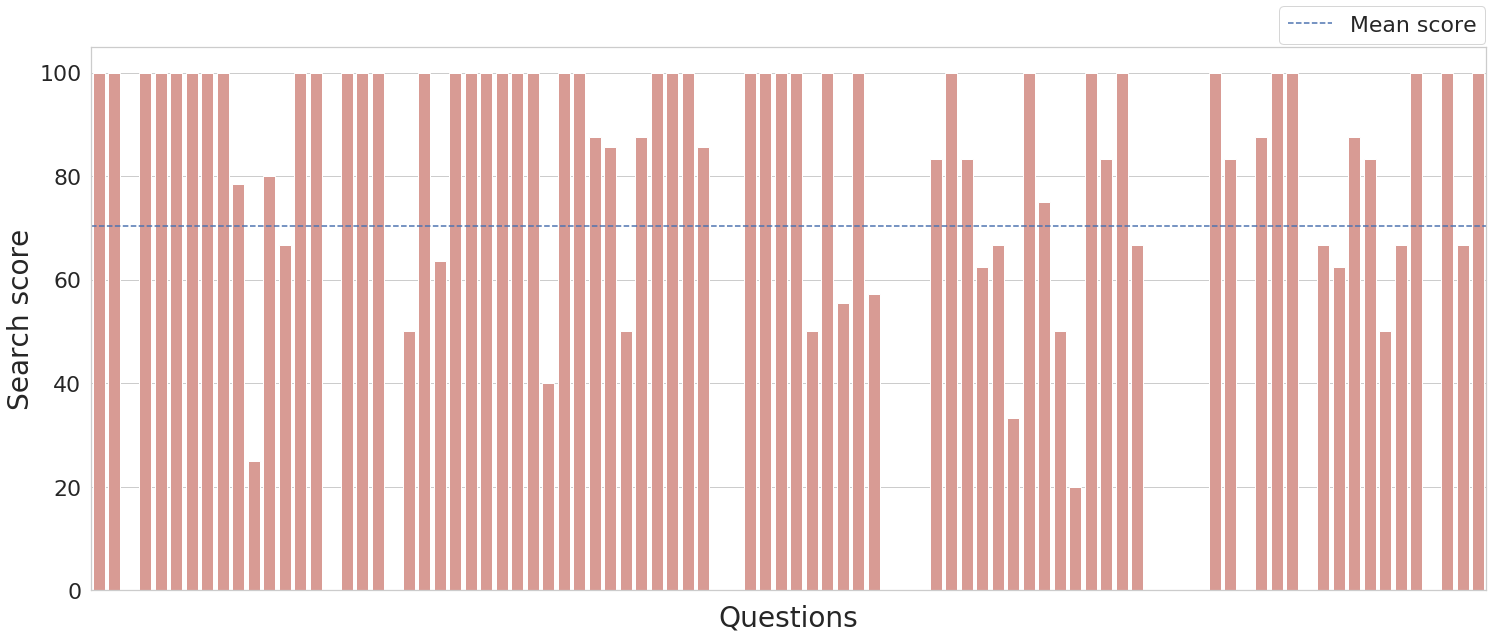

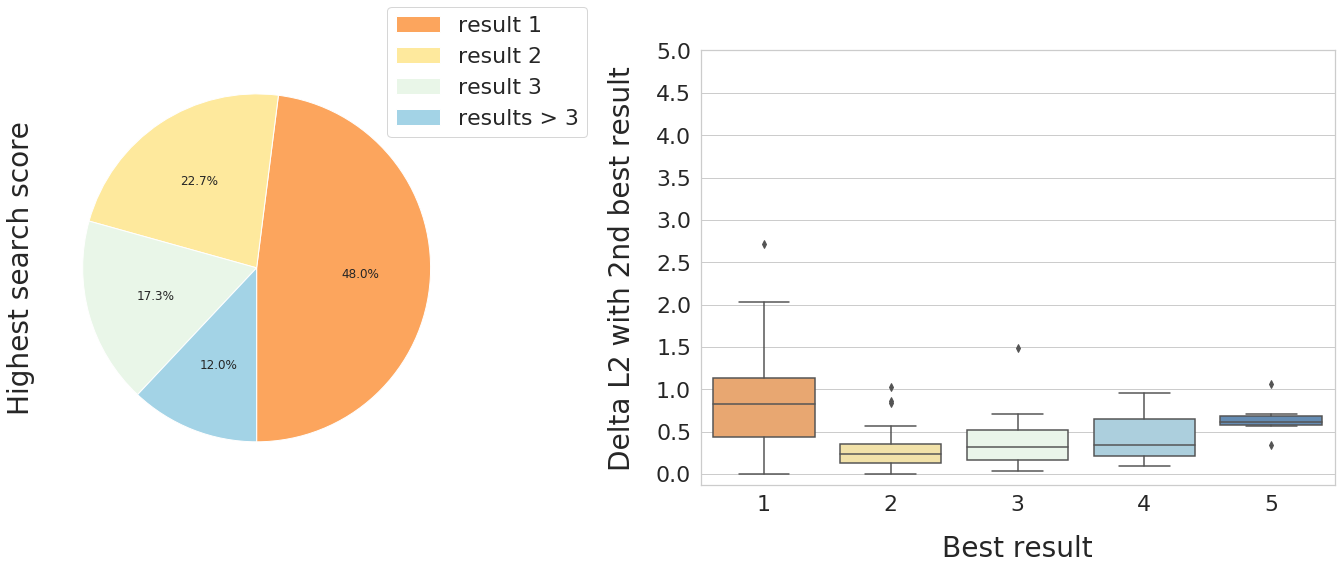


Done.


In [98]:
run(
    model_name_or_path='/raid/antoloui/Master-thesis/_models/netbert-final/',
    embeddings_filepath='/raid/antoloui/Master-thesis/_data/information_retrieval/embeddings/netbert_embeddings.h5',
    questions_filepath='/raid/antoloui/Master-thesis/_data/information_retrieval/questions.csv', 
    questions_type='Knowledge',
    topk=5,
    fig_name="netbert"
)

### 1.2. BERT


Load chunks and their embeddings...

Create FAISS (GPU) index...

Load questions...

Encode questions...
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 70 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...

Perform evaluation...



  MEAN SCORE: 59.40

Plot results...


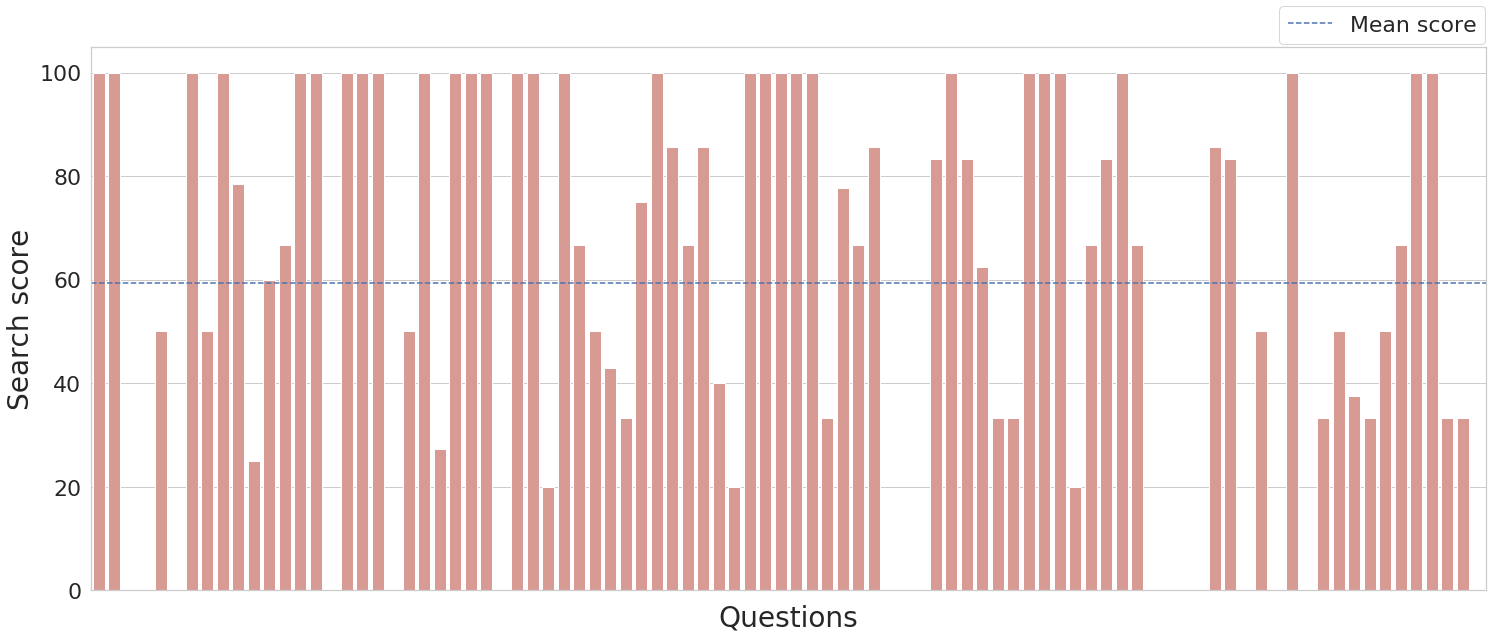

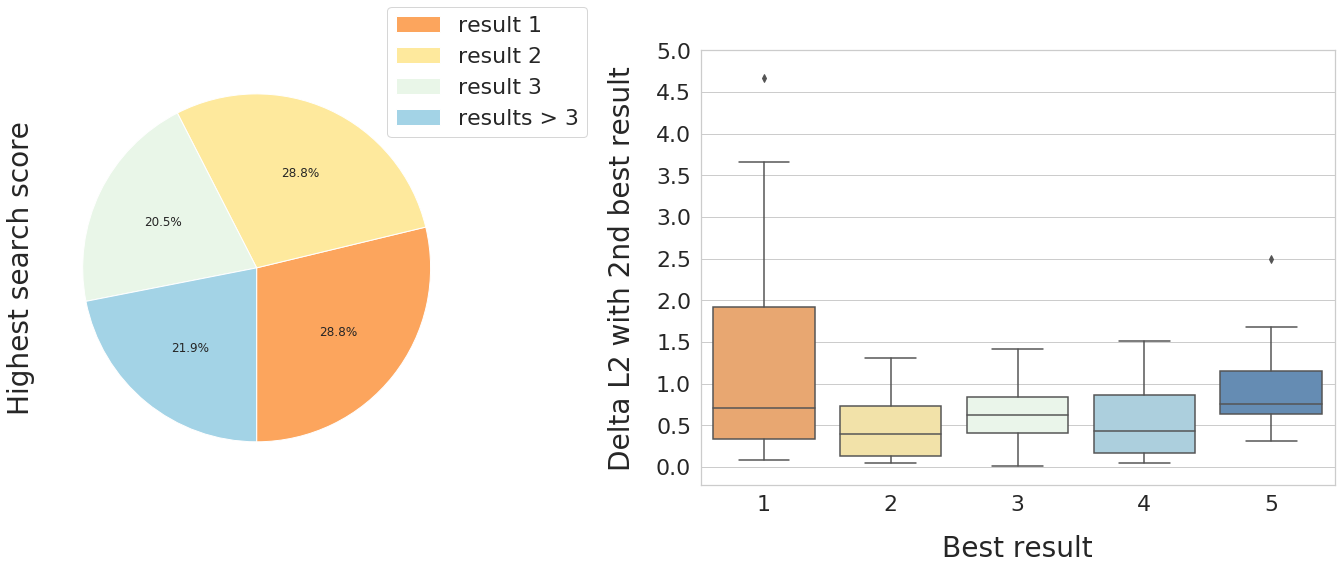


Done.


In [99]:
run(
    model_name_or_path='bert-base-cased',
    embeddings_filepath='/raid/antoloui/Master-thesis/_data/information_retrieval/embeddings/bert_embeddings.h5',
    questions_filepath='/raid/antoloui/Master-thesis/_data/information_retrieval/questions.csv',
    questions_type='Knowledge',
    topk=5,
    fig_name="bert"
)

## 2. "Scenario" questions

### 2.1. NetBERT


Load chunks and their embeddings...

Create FAISS (GPU) index...

Load questions...

Encode questions...
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 125 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...

Perform evaluation...



  MEAN SCORE: 58.92

Plot results...


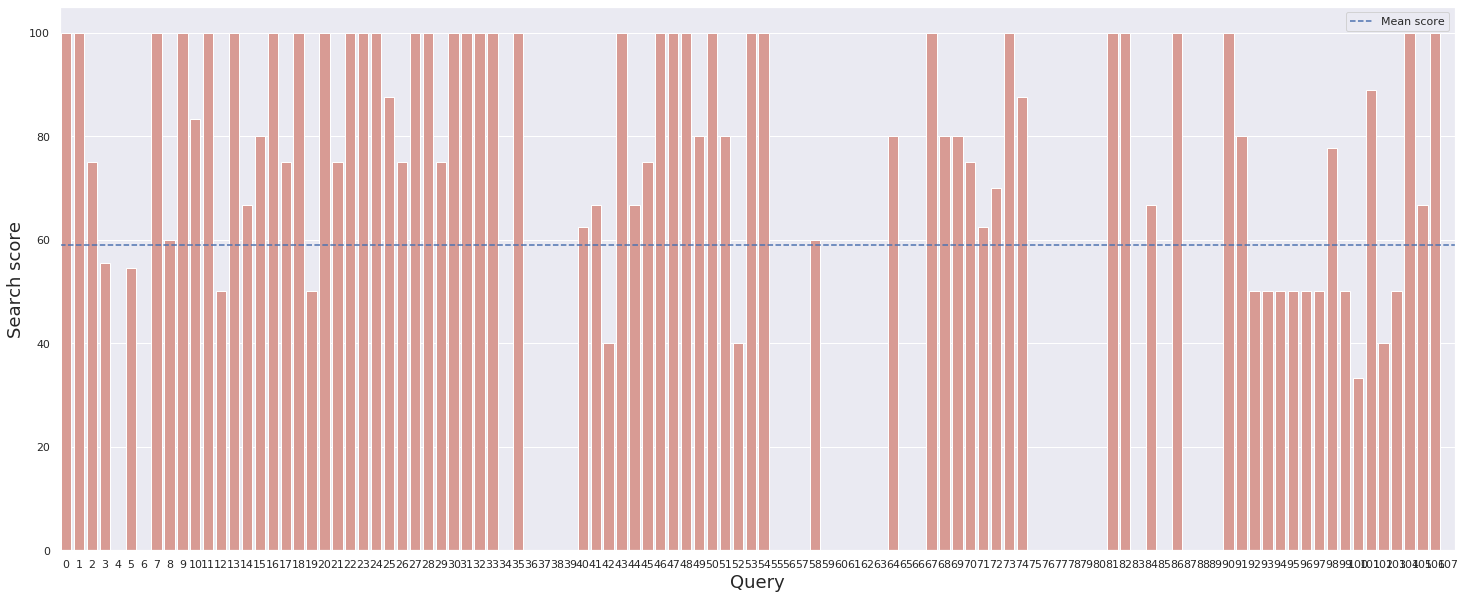

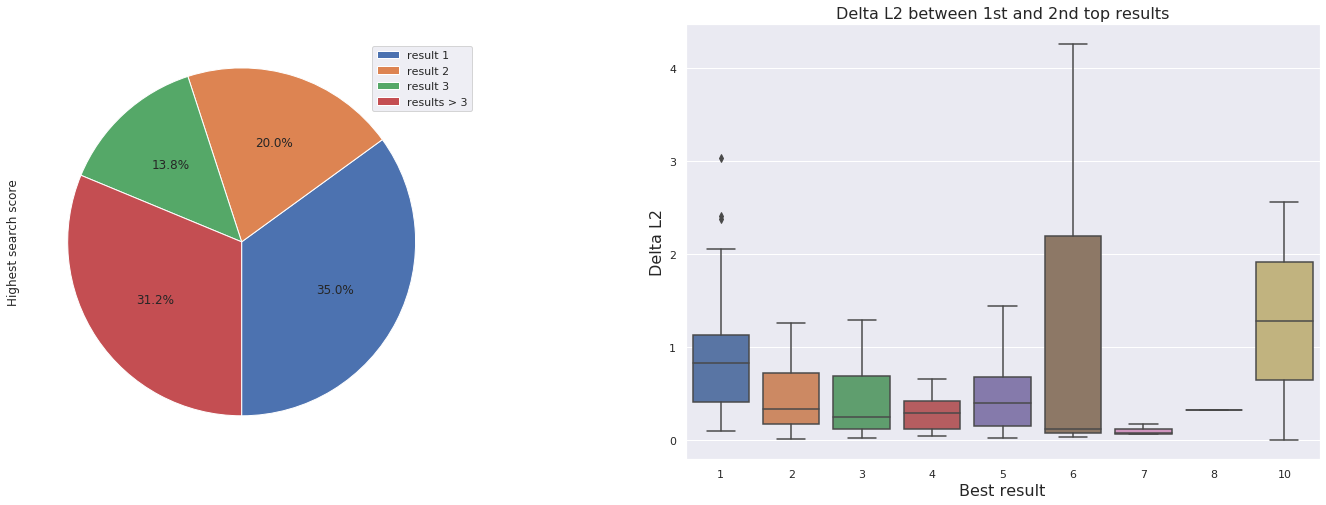


Done.


In [57]:
run(
    model_name_or_path='/raid/antoloui/Master-thesis/Code/_models/netbert-830000/',
    embeddings_filepath='/raid/antoloui/Master-thesis/Data/QA/embeddings/netbert_embeddings.h5',
    questions_filepath='/raid/antoloui/Master-thesis/Data/QA/questions.csv', 
    questions_type='Scenario'
)

### 2.2. BERT


Load chunks and their embeddings...

Create FAISS (GPU) index...

Load questions...

Encode questions...
   Loading pretrained model/tokenizer...
   Tokenizing sentences...
   Padding/Truncating sentences to 125 tokens...
   Creating attention masks...
   Converting inputs to torch tensors...
   Encoding sentences...

Perform evaluation...



  MEAN SCORE: 54.20

Plot results...


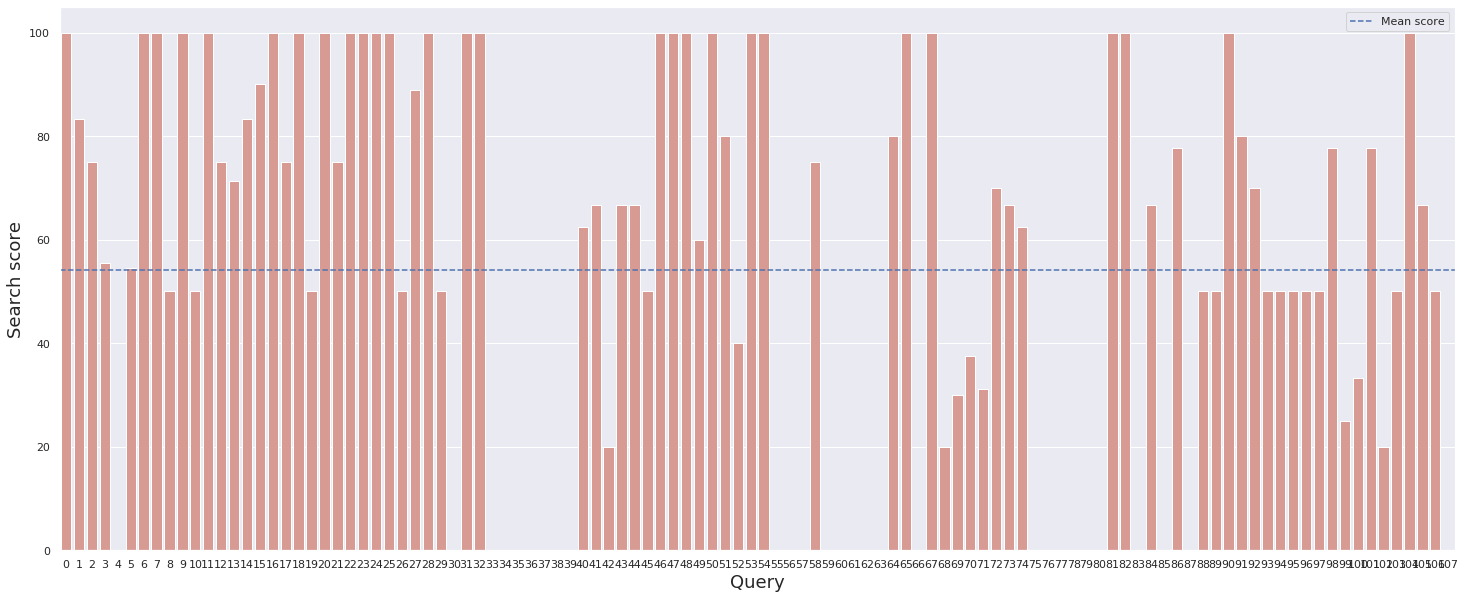

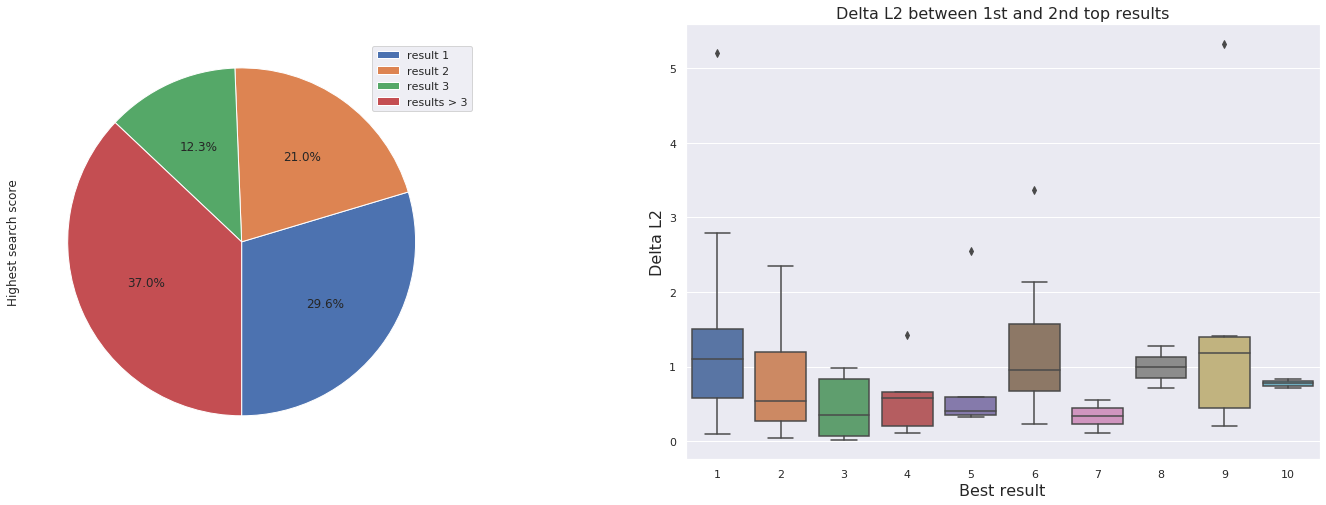


Done.


In [58]:
run(
    model_name_or_path='bert-base-cased',
    embeddings_filepath='/raid/antoloui/Master-thesis/Data/QA/embeddings/bert_embeddings.h5',
    questions_filepath='/raid/antoloui/Master-thesis/Data/QA/questions.csv',
    questions_type='Scenario'
)